In [228]:
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [229]:
lem = WordNetLemmatizer() #create lemmatizer

In [230]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kseniapavlina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [288]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary

,word,cat_lev1,cat_lev2,cat_lev3,ndf
0,information,business,professional_conduct_host,advice,0.008904
1,recommendations,business,professional_conduct_host,advice,0.008375
2,tips,business,professional_conduct_host,advice,0.008399
3,advice,business,professional_conduct_host,advice,0.007568
4,suggestions,business,professional_conduct_host,advice,0.007580
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moments,social,social_interaction,talking,0.001155
350,chats,social,social_interaction,talking,0.000553


In [289]:
dictionary[70:]

,word,cat_lev1,cat_lev2,cat_lev3,ndf
70,welcome,business,professional_conduct_host,personality_host2,0.009818
71,responsive,business,professional_conduct_host,personality_host2,0.009638
72,help,business,professional_conduct_host,personality_host2,0.008736
73,welcomed,business,professional_conduct_host,personality_host2,0.008543
74,needs,business,professional_conduct_host,personality_host2,0.008567
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moments,social,social_interaction,talking,0.001155
350,chats,social,social_interaction,talking,0.000553


In [290]:
dictionary['word'] = dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

In [233]:
filepath = '../data/en_reviews/Manchester.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs
0,0,68951,993691,2012-03-12,1602133,Leopoldo,Comfy and cosy space with a welcome survival k...,en
1,1,68951,1305184,2012-05-19,2093255,Deepthi,We stayed with Paul for 2 nights on a business...,en
2,2,68951,1369794,2012-05-29,337778,Graham,What a fantastic place. We stayed for a week ...,en
3,3,68951,1470176,2012-06-12,1829716,Kira,The house is very comfortable and the hosts ar...,en
4,4,68951,1607783,2012-07-02,323672,Peter,My friends and I had a great stay at Paul and ...,en
...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,Steve's place is quite basic but had everythin...,en
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,It was great experience. It is quite and big r...,en
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,Was beyond my expectations and super friendly,en
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,"Well thought out character property, extremely...",en


In [234]:
table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

In [235]:
#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en
...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en


In [236]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [237]:
#### DELETE THIS LATER ###
# mask = (reviews['date'] > '2014-01-01') & (reviews['date'] < '2015-01-01')
# reviews1 = reviews.loc[mask].copy()
# reviews1

In [238]:
allwords = reviews['comments'].tolist()
allwords = " ".join(allwords)
unique_words = set(allwords.split(' '))
len(unique_words)

37437

In [239]:
unique_words = list(unique_words)
unique_words = [string for string in unique_words if string != ""]
len(unique_words)

37436

In [240]:
unique_words[2]

'paid'

In [241]:
# unique_words = " ".join(unique_words)

In [242]:
# import math
# def getNom(word, review):
#     nom = 1
    

In [243]:
# import math
# def logTermFrequency(word, review):
#     totalNumberOfWords = review.split()
#     totalNumberOfWords = len(totalNumberOfWords)
#     numberOfWord = math.log(1 + review.count(word))
#     if numberOfWord == 0:
#         return 0;
#     result = numberOfWord * 100/ totalNumberOfWords
#     return result   

In [244]:
# it mayyyy have to be log10
import math
def getDenom(review, unique_words):
    den = 0
    for word in unique_words:
        den += math.log(1 + review.count(word))
    return den

In [245]:
reviews['den'] = reviews['comments'].apply(lambda x: getDenom(x, unique_words))
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424
...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233


In [246]:
# same with log here
def getNom(category, review, dictionary):
    nom = 0
    dictionaryWords = dictionary[(dictionary['cat_lev3'] == category)]
    dictionaryWords = dictionaryWords['word']
    for word in dictionaryWords:
        nom += math.log(1 + review.count(word))
    return nom

In [248]:
reviews['meal0'] = reviews['comments'].apply(lambda x: getNom('meal', x, dictionary))
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000
...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000


In [249]:
reviews['meal'] = reviews['meal0']*100/reviews['den']
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,meal
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,0.822517
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,0.000000
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,0.000000
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,0.000000
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,0.000000
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,0.000000
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,0.000000


In [250]:
reviews['people0'] = reviews['comments'].apply(lambda x: getNom('people', x, dictionary))
reviews['people'] = reviews['people0']*100/reviews['den']
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,meal,people0,people
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,0.822517,0.693147,0.411258
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,0.000000,2.708050,1.134329
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,0.000000,2.639057,1.267439
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,0.000000,5.257495,2.355324
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,0.000000,3.688879,1.479829
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,0.000000,1.386294,1.165671
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,0.000000,0.000000,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,0.000000,1.386294,2.898482
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,0.000000,1.098612,0.810316


In [251]:
# reviews1['meal'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('meal', x, dictionary, unique_words))

In [252]:
k_meal = reviews['meal'].loc[reviews['meal'] > 0]
k_meal = k_meal.min()
print(k_meal)

0.061698700769988915


In [291]:
reviews['personality_host0'] = reviews['comments'].apply(lambda x: getNom('personality_host', x, dictionary))
reviews['personality_host'] = reviews['personality_host0']*100/reviews['den']

In [293]:
reviews['personality_host20'] = reviews['comments'].apply(lambda x: getNom('personality_host2', x, dictionary))
reviews['personality_host2'] = reviews['personality_host20']*100/reviews['den']

In [294]:
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,...,logistic0,logistic,personality_host20,personality_host2,location0,location,property_type0,property_type,facilities0,facilities
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,...,0.000000,0.000000,1.791759,1.063087,3.871201,2.296862,0.000000,0.000000,0.000000,0.000000
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,...,0.693147,0.290341,0.000000,0.000000,0.693147,0.290341,0.000000,0.000000,0.693147,0.290341
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.545177,2.663139,0.693147,0.332892,0.000000,0.000000
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,...,0.000000,0.000000,2.772589,1.242102,1.386294,0.621051,1.386294,0.621051,0.000000,0.000000
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,...,0.000000,0.000000,2.079442,0.834188,8.723231,3.499407,1.098612,0.440719,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,...,0.000000,0.000000,0.693147,0.582836,0.693147,0.582836,0.000000,0.000000,0.000000,0.000000
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,...,0.000000,0.000000,2.079442,1.533758,1.386294,1.022505,1.386294,1.022505,0.693147,0.511253


In [253]:
# reviews['meal'] = reviews['comments'].apply(lambda x: adoptionForOneReview('meal', x, dictionary))
# reviews1['people'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('people', x, dictionary, unique_words))
# reviews['personality_host0'] = reviews['comments'].apply(lambda x: getNom('personality_host', x, dictionary))
# reviews['personality_host'] = reviews['personality_host0']*100/reviews['den']
reviews['sharing0'] = reviews['comments'].apply(lambda x: getNom('sharing', x, dictionary))
reviews['sharing'] = reviews['sharing0']*100/reviews['den']
reviews['talking0'] = reviews['comments'].apply(lambda x: getNom('talking', x, dictionary))
reviews['talking'] = reviews['talking0']*100/reviews['den']


# reviews1['personality_host'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('personality_host', x, dictionary, unique_words))
# reviews1['sharing'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('sharing', x, dictionary, unique_words))
# reviews1['talking'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('talking', x, dictionary, unique_words))
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,meal,people0,people,personality_host0,personality_host,sharing0,sharing,talking0,talking
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,0.822517,0.693147,0.411258,2.484907,1.474346,0.000000,0.000000,0.0,0.0
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,0.000000,2.708050,1.134329,0.000000,0.000000,0.693147,0.290341,0.0,0.0
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,0.000000,2.639057,1.267439,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,0.000000,5.257495,2.355324,3.465736,1.552627,0.000000,0.000000,0.0,0.0
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,0.000000,3.688879,1.479829,2.079442,0.834188,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,0.000000,1.386294,1.165671,0.693147,0.582836,0.000000,0.000000,0.0,0.0
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.887423,0.0,0.0
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,0.000000,1.386294,2.898482,0.693147,1.449241,0.000000,0.000000,0.0,0.0
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,0.000000,1.098612,0.810316,2.079442,1.533758,0.000000,0.000000,0.0,0.0


In [254]:
reviews['interiors0'] = reviews['comments'].apply(lambda x: getNom('interiors', x, dictionary))
reviews['interiors'] = reviews['interiors0']*100/reviews['den']
reviews['communication0'] = reviews['comments'].apply(lambda x: getNom('communication', x, dictionary))
reviews['communication'] = reviews['communication0']*100/reviews['den']
reviews['advice0'] = reviews['comments'].apply(lambda x: getNom('advice', x, dictionary))
reviews['advice'] = reviews['advice0']*100/reviews['den']
reviews['logistic0'] = reviews['comments'].apply(lambda x: getNom('logistic', x, dictionary))
reviews['logistic'] = reviews['logistic0']*100/reviews['den']
# reviews['personality_host20'] = reviews['comments'].apply(lambda x: getNom('personality_host2', x, dictionary))
# reviews['personality_host2'] = reviews['personality_host20']*100/reviews['den']
reviews['location0'] = reviews['comments'].apply(lambda x: getNom('location', x, dictionary))
reviews['location'] = reviews['location0']*100/reviews['den']
reviews['property_type0'] = reviews['comments'].apply(lambda x: getNom('property_type', x, dictionary))
reviews['property_type'] = reviews['property_type0']*100/reviews['den']
reviews['facilities0'] = reviews['comments'].apply(lambda x: getNom('facilities', x, dictionary))
reviews['facilities'] = reviews['facilities0']*100/reviews['den']

# reviews['business'] = reviews['comments'].apply(lambda x: adoptionForOneReview('business', x, dictionary))
# reviews1['communication'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('communication', x, dictionary, unique_words))
# reviews1['advice'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('advice', x, dictionary, unique_words))
# reviews1['logistic'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('logistic', x, dictionary, unique_words))
# reviews1['personality_host2'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('personality_host2', x, dictionary, unique_words))
# reviews1['location'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('location', x, dictionary, unique_words))
# reviews1['property_type'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('property_type', x, dictionary, unique_words))
# reviews1['facilities'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('facilities', x, dictionary, unique_words))
# reviews1['interiors'] = reviews1['comments'].apply(lambda x: adoptionForOneReview('interiors', x, dictionary, unique_words))

reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,...,logistic0,logistic,personality_host20,personality_host2,location0,location,property_type0,property_type,facilities0,facilities
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,...,0.000000,0.000000,0,0.0,3.871201,2.296862,0.000000,0.000000,0.000000,0.000000
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,...,0.693147,0.290341,0,0.0,0.693147,0.290341,0.000000,0.000000,0.693147,0.290341
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,...,0.000000,0.000000,0,0.0,5.545177,2.663139,0.693147,0.332892,0.000000,0.000000
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,...,0.000000,0.000000,0,0.0,1.386294,0.621051,1.386294,0.621051,0.000000,0.000000
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,...,0.000000,0.000000,0,0.0,8.723231,3.499407,1.098612,0.440719,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,...,0.000000,0.000000,0,0.0,0.693147,0.582836,0.000000,0.000000,0.000000,0.000000
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,...,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,...,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,...,0.000000,0.000000,0,0.0,1.386294,1.022505,1.386294,1.022505,0.693147,0.511253


In [274]:
# reviews['personality_host20'] = reviews['comments'].apply(lambda x: getNom('personality_host2', x, dictionary))
# reviews['personality_host2'] = reviews['personality_host20']*100/reviews['den']

In [295]:
reviews

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,den,meal0,...,logistic0,logistic,personality_host20,personality_host2,location0,location,property_type0,property_type,facilities0,facilities
0,0,68951,993691,2012-03-12,1602133,Leopoldo,comfy and cosy space with a welcome survival k...,en,168.543005,1.386294,...,0.000000,0.000000,1.791759,1.063087,3.871201,2.296862,0.000000,0.000000,0.000000,0.000000
1,1,68951,1305184,2012-05-19,2093255,Deepthi,we stayed with paul for 2 night on a business ...,en,238.735779,0.000000,...,0.693147,0.290341,0.000000,0.000000,0.693147,0.290341,0.000000,0.000000,0.693147,0.290341
2,2,68951,1369794,2012-05-29,337778,Graham,what a fantastic place we stayed for a week an...,en,208.219637,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.545177,2.663139,0.693147,0.332892,0.000000,0.000000
3,3,68951,1470176,2012-06-12,1829716,Kira,the house is very comfortable and the host are...,en,223.217534,0.000000,...,0.000000,0.000000,2.772589,1.242102,1.386294,0.621051,1.386294,0.621051,0.000000,0.000000
4,4,68951,1607783,2012-07-02,323672,Peter,my friend and i had a great stay at paul and d...,en,249.277424,0.000000,...,0.000000,0.000000,2.079442,0.834188,8.723231,3.499407,1.098612,0.440719,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132579,144022,42135683,604472776,2020-02-11,326617985,Effanga,steves place is quite basic but had everything...,en,118.926682,0.000000,...,0.000000,0.000000,0.693147,0.582836,0.693147,0.582836,0.000000,0.000000,0.000000,0.000000
132580,144023,42135683,605332428,2020-02-14,30514766,Gökçe,it wa great experience it is quite and big roo...,en,78.107827,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132581,144024,42135683,605817713,2020-02-15,103013271,Rich,wa beyond my expectation and super friendly,en,47.828284,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
132582,144026,42167098,606283081,2020-02-16,221655974,Karl,well thought out character property extremely ...,en,135.578233,0.000000,...,0.000000,0.000000,2.079442,1.533758,1.386294,1.022505,1.386294,1.022505,0.693147,0.511253


In [296]:
k_communication= reviews['communication'].loc[reviews['communication'] > 0]
k_advice = reviews['advice'].loc[reviews['advice'] > 0]
k_personality_host2 = reviews['personality_host2'].loc[reviews['personality_host2'] > 0]
k_logistic= reviews['logistic'].loc[reviews['logistic'] > 0]
k_location = reviews['location'].loc[reviews['location'] > 0]
k_property_type= reviews['property_type'].loc[reviews['property_type'] > 0]
k_facilities = reviews['facilities'].loc[reviews['facilities'] > 0]
k_interiors = reviews['interiors'].loc[reviews['interiors'] > 0]

k_communication = k_communication.min()
k_advice = k_advice.min()
k_personality_host2 = k_personality_host2.min()
k_logistic = k_logistic.min()
k_location = k_location.min()
k_property_type = k_property_type.min()
k_facilities = k_facilities.min()
k_interiors = k_interiors.min()
print(k_communication)
print(k_advice)
print(k_personality_host2)
print(k_logistic)
print(k_location)
print(k_property_type)
print(k_facilities)
print(k_interiors)

0.07617694870631049
0.058678416960691454
0.06744363942926118
0.05926202049336858
0.1260235912615128
0.06697074880576302
0.062114923509901054
0.0932791810398453


In [297]:
k_meal = reviews['meal'].loc[reviews['meal'] > 0]
k_people = reviews['people'].loc[reviews['people'] > 0]
k_personality_host = reviews['personality_host'].loc[reviews['personality_host'] > 0]
k_sharing = reviews['sharing'].loc[reviews['sharing'] > 0]
k_talking = reviews['talking'].loc[reviews['talking'] > 0]
k_meal = k_meal.min()
k_people = k_people.min()
k_personality_host = k_personality_host.min()
k_sharing = k_sharing.min()
k_talking = k_talking.min()
print(k_meal)
print(k_people)
print(k_personality_host)
print(k_sharing)
print(k_talking)

0.061698700769988915
0.21000091837855758
0.06697074880576302
0.061698700769988915
0.062114923509901054


In [263]:
def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
    adoption = 1
    mask = (setOfReviews['date'] > startDate) & (setOfReviews['date'] < endDate)
    setOfReviews = setOfReviews.loc[mask]
    setOfReviews = setOfReviews[category]
    for review in setOfReviews:
        adoption *= (review + k)**(1 / len(setOfReviews))
    adoption = adoption - k
    return adoption

In [298]:
d2 = {'Year': [2010, 2010, 2010, 2010, 2010, 2010, 2010,2010, 2011,2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012,2012,
              2013, 2013,2013, 2013, 2013, 2013, 2013, 2013,2014,2014, 2014, 2014, 2014, 2014,2014, 2014, 2015, 2015,2015, 2015, 2015, 2015, 2015, 2015, 
              2016, 2016,2016, 2016, 2016, 2016,2016, 2016, 2017,2017, 2017, 2017, 2017, 2017, 2017, 2017,2018, 2018, 2018, 2018, 2018,2018,2018, 2018,
              2019, 2019, 2019,2019, 2019, 2019, 2019, 2019], 'Business sub-category' : ['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                                                  'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                     
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors'], 'value':0.0}
business_out = pd.DataFrame(data=d2)
business_out

,Year,Business sub-category,value
0,2010,location,0.0
1,2010,communication,0.0
2,2010,personality_host,0.0
3,2010,property_type,0.0
4,2010,logistic,0.0
...,...,...,...
75,2019,property_type,0.0
76,2019,logistic,0.0
77,2019,advice,0.0
78,2019,facilities,0.0


In [299]:
d = {'Year': [2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 
              2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 
              2016, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 
              2019, 2019, 2019, 2019, 2019], 'Social sub-category' : ['meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking'], 'value':0.0}
social_out = pd.DataFrame(data=d)
social_out

,Year,Social sub-category,value
0,2010,meal,0.0
1,2010,people,0.0
2,2010,personality_host,0.0
3,2010,sharing,0.0
4,2010,talking,0.0
5,2011,meal,0.0
6,2011,people,0.0
7,2011,personality_host,0.0
8,2011,sharing,0.0
9,2011,talking,0.0


In [300]:
business_out.at[0, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2010-01-01', '2011-01-01', k_location)
business_out.at[8, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2011-01-01', '2012-01-01', k_location)
business_out.at[16, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2012-01-01', '2013-01-01', k_location)
business_out.at[24, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2013-01-01', '2014-01-01', k_location)
business_out.at[32, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2014-01-01', '2015-01-01', k_location)
business_out.at[40, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2015-01-01', '2016-01-01', k_location)
business_out.at[48, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2016-01-01', '2017-01-01', k_location)
business_out.at[56, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2017-01-01', '2018-01-01', k_location)
business_out.at[64, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2018-01-01', '2019-01-01', k_location)
business_out.at[72, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2019-01-01', '2020-01-01', k_location)

business_out.at[1, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2010-01-01', '2011-01-01', k_communication)
business_out.at[9, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2011-01-01', '2012-01-01', k_communication)
business_out.at[17, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2012-01-01', '2013-01-01', k_communication)
business_out.at[25, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2013-01-01', '2014-01-01', k_communication)
business_out.at[33, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2014-01-01', '2015-01-01', k_communication)
business_out.at[41, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2015-01-01', '2016-01-01', k_communication)
business_out.at[49, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2016-01-01', '2017-01-01', k_communication)
business_out.at[57, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2017-01-01', '2018-01-01', k_communication)
business_out.at[65, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2018-01-01', '2019-01-01', k_communication)
business_out.at[73, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2019-01-01', '2020-01-01', k_communication)

business_out.at[2, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2010-01-01', '2011-01-01', k_personality_host2)
business_out.at[10, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2011-01-01', '2012-01-01', k_personality_host2)
business_out.at[18, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2012-01-01', '2013-01-01', k_personality_host2)
business_out.at[25, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2013-01-01', '2014-01-01', k_personality_host2)
business_out.at[34, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2014-01-01', '2015-01-01', k_personality_host2)
business_out.at[42, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2015-01-01', '2016-01-01', k_personality_host2)
business_out.at[50, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2016-01-01', '2017-01-01', k_personality_host2)
business_out.at[58, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2017-01-01', '2018-01-01', k_personality_host2)
business_out.at[66, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2018-01-01', '2019-01-01', k_personality_host2)
business_out.at[74, 'value'] = adoptionForSetOfReviews('personality_host2', reviews, dictionary, '2019-01-01', '2020-01-01', k_personality_host2)

business_out.at[3, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2010-01-01', '2011-01-01', k_property_type)
business_out.at[11, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2011-01-01', '2012-01-01', k_property_type)
business_out.at[19, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2012-01-01', '2013-01-01', k_property_type)
business_out.at[26, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2013-01-01', '2014-01-01', k_property_type)
business_out.at[35, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2014-01-01', '2015-01-01', k_property_type)
business_out.at[43, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2015-01-01', '2016-01-01', k_property_type)
business_out.at[51, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2016-01-01', '2017-01-01', k_property_type)
business_out.at[59, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2017-01-01', '2018-01-01', k_property_type)
business_out.at[67, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2018-01-01', '2019-01-01', k_property_type)
business_out.at[75, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2019-01-01', '2020-01-01', k_property_type)

business_out.at[4, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2010-01-01', '2011-01-01', k_logistic)
business_out.at[12, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2011-01-01', '2012-01-01', k_logistic)
business_out.at[20, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2012-01-01', '2013-01-01', k_logistic)
business_out.at[27, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2013-01-01', '2014-01-01', k_logistic)
business_out.at[36, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2014-01-01', '2015-01-01', k_logistic)
business_out.at[44, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2015-01-01', '2016-01-01', k_logistic)
business_out.at[52, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2016-01-01', '2017-01-01', k_logistic)
business_out.at[60, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2017-01-01', '2018-01-01', k_logistic)
business_out.at[68, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2018-01-01', '2019-01-01', k_logistic)
business_out.at[76, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2019-01-01', '2020-01-01', k_logistic)

business_out.at[5, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2010-01-01', '2011-01-01', k_advice)
business_out.at[13, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2011-01-01', '2012-01-01', k_advice)
business_out.at[21, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2012-01-01', '2013-01-01', k_advice)
business_out.at[29, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2013-01-01', '2014-01-01', k_advice)
business_out.at[37, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2014-01-01', '2015-01-01', k_advice)
business_out.at[45, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2015-01-01', '2016-01-01', k_advice)
business_out.at[53, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2016-01-01', '2017-01-01', k_advice)
business_out.at[61, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2017-01-01', '2018-01-01', k_advice)
business_out.at[69, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2018-01-01', '2019-01-01', k_advice)
business_out.at[77, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2019-01-01', '2020-01-01', k_advice)

business_out.at[6, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2010-01-01', '2011-01-01', k_facilities)
business_out.at[14, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2011-01-01', '2012-01-01', k_facilities)
business_out.at[22, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2012-01-01', '2013-01-01', k_facilities)
business_out.at[30, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2013-01-01', '2014-01-01', k_facilities)
business_out.at[38, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2014-01-01', '2015-01-01', k_facilities)
business_out.at[46, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2015-01-01', '2016-01-01', k_facilities)
business_out.at[54, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2016-01-01', '2017-01-01', k_facilities)
business_out.at[62, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2017-01-01', '2018-01-01', k_facilities)
business_out.at[70, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2018-01-01', '2019-01-01', k_facilities)
business_out.at[78, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2019-01-01', '2020-01-01', k_facilities)

business_out.at[7, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2010-01-01', '2011-01-01', k_interiors)
business_out.at[15, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2011-01-01', '2012-01-01', k_interiors)
business_out.at[23, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2012-01-01', '2013-01-01', k_interiors)
business_out.at[31, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2013-01-01', '2014-01-01', k_interiors)
business_out.at[39, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2014-01-01', '2015-01-01', k_interiors)
business_out.at[47, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2015-01-01', '2016-01-01', k_interiors)
business_out.at[55, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2016-01-01', '2017-01-01', k_interiors)
business_out.at[63, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2017-01-01', '2018-01-01', k_interiors)
business_out.at[71, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2018-01-01', '2019-01-01', k_interiors)
business_out.at[79, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2019-01-01', '2020-01-01', k_interiors)

# # print(adoptionForSetOfReviews('location', reviews, dictionary, '2010-01-01', '2011-01-01', k_location))
business_out


,Year,Business sub-category,value
0,2010,location,0.873976
1,2010,communication,0.923823
2,2010,personality_host,0.932556
3,2010,property_type,0.933029
4,2010,logistic,0.940738
...,...,...,...
75,2019,property_type,0.116285
76,2019,logistic,0.028175
77,2019,advice,0.009713
78,2019,facilities,0.013699


In [301]:
social_out.at[0, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal)
social_out.at[5, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2011-01-01', '2012-01-01', k_meal)
social_out.at[10, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2012-01-01', '2013-01-01', k_meal)
social_out.at[15, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2013-01-01', '2014-01-01', k_meal)
social_out.at[20, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2014-01-01', '2015-01-01', k_meal)
social_out.at[25, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2015-01-01', '2016-01-01', k_meal)
social_out.at[30, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2016-01-01', '2017-01-01', k_meal)
social_out.at[35, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2017-01-01', '2018-01-01', k_meal)
social_out.at[40, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2018-01-01', '2019-01-01', k_meal)
social_out.at[45, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2019-01-01', '2020-01-01', k_meal)

social_out.at[1, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2010-01-01', '2011-01-01', k_people)
social_out.at[6, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2011-01-01', '2012-01-01', k_people)
social_out.at[11, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2012-01-01', '2013-01-01', k_people)
social_out.at[16, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2013-01-01', '2014-01-01', k_people)
social_out.at[21, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2014-01-01', '2015-01-01', k_people)
social_out.at[26, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2015-01-01', '2016-01-01', k_people)
social_out.at[31, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2016-01-01', '2017-01-01', k_people)
social_out.at[36, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2017-01-01', '2018-01-01', k_people)
social_out.at[41, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2018-01-01', '2019-01-01', k_people)
social_out.at[46, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2019-01-01', '2020-01-01', k_people)

social_out.at[2, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2010-01-01', '2011-01-01', k_personality_host)
social_out.at[7, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2011-01-01', '2012-01-01', k_personality_host)
social_out.at[12, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2012-01-01', '2013-01-01', k_personality_host)
social_out.at[17, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2013-01-01', '2014-01-01', k_personality_host)
social_out.at[22, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2014-01-01', '2015-01-01', k_personality_host)
social_out.at[27, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2015-01-01', '2016-01-01', k_personality_host)
social_out.at[32, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2016-01-01', '2017-01-01', k_personality_host)
social_out.at[37, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2017-01-01', '2018-01-01', k_personality_host)
social_out.at[42, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2018-01-01', '2019-01-01', k_personality_host)
social_out.at[47, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2019-01-01', '2020-01-01', k_personality_host)

social_out.at[3, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2010-01-01', '2011-01-01', k_sharing)
social_out.at[8, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2011-01-01', '2012-01-01', k_sharing)
social_out.at[13, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2012-01-01', '2013-01-01', k_sharing)
social_out.at[18, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2013-01-01', '2014-01-01', k_sharing)
social_out.at[23, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2014-01-01', '2015-01-01', k_sharing)
social_out.at[28, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2015-01-01', '2016-01-01', k_sharing)
social_out.at[33, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2016-01-01', '2017-01-01', k_sharing)
social_out.at[38, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2017-01-01', '2018-01-01', k_sharing)
social_out.at[43, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2018-01-01', '2019-01-01', k_sharing)
social_out.at[48, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2019-01-01', '2020-01-01', k_sharing)

social_out.at[4, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2010-01-01', '2011-01-01', k_talking)
social_out.at[9, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2011-01-01', '2012-01-01', k_talking)
social_out.at[14, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2012-01-01', '2013-01-01', k_talking)
social_out.at[19, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2013-01-01', '2014-01-01', k_talking)
social_out.at[24, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2014-01-01', '2015-01-01', k_talking)
social_out.at[29, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2015-01-01', '2016-01-01', k_talking)
social_out.at[34, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2016-01-01', '2017-01-01', k_talking)
social_out.at[39, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2017-01-01', '2018-01-01', k_talking)
social_out.at[44, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2018-01-01', '2019-01-01', k_talking)
social_out.at[49, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2019-01-01', '2020-01-01', k_talking)
# # print(adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal))
social_out


,Year,Social sub-category,value
0,2010,meal,9.383013e-01
1,2010,people,7.899991e-01
2,2010,personality_host,9.330293e-01
3,2010,sharing,9.383013e-01
4,2010,talking,9.378851e-01
5,2011,meal,-3.469447e-17
6,2011,people,1.511125e+00
7,2011,personality_host,8.118806e-02
8,2011,sharing,2.037474e-02
9,2011,talking,6.938894e-17


In [223]:
# for2010b = adoptionForSetOfReviews('business', reviews, dictionary, '2010-01-01', '2011-01-01', k_business)
# for2011b = adoptionForSetOfReviews('business', reviews, dictionary, '2011-01-01', '2012-01-01', k_business)
# for2012b = adoptionForSetOfReviews('business', reviews, dictionary, '2012-01-01', '2013-01-01', k_business)
# for2013b = adoptionForSetOfReviews('business', reviews, dictionary, '2013-01-01', '2014-01-01', k_business)
# for2014b = adoptionForSetOfReviews('business', reviews, dictionary, '2014-01-01', '2015-01-01', k_business)
# for2015b = adoptionForSetOfReviews('business', reviews, dictionary, '2015-01-01', '2016-01-01', k_business)
# for2016b = adoptionForSetOfReviews('business', reviews, dictionary, '2016-01-01', '2017-01-01', k_business)
# for2017b = adoptionForSetOfReviews('business', reviews, dictionary, '2017-01-01', '2018-01-01', k_business)
# for2018b = adoptionForSetOfReviews('business', reviews, dictionary, '2018-01-01', '2019-01-01', k_business)
# for2019b = adoptionForSetOfReviews('business', reviews, dictionary, '2019-01-01', '2020-01-01', k_business)

# print("business")
# print("2010 = ",for2010b)
# print("2011 = ",for2011b)
# print("2012 = ",for2012b)
# print("2013 = ",for2013b)
# print("2014 = ",for2014b)
# print("2015 = ",for2015b)
# print("2016 = ",for2016b)
# print("2017 = ",for2017b)
# print("2018 = ",for2018b)
# print("2019 = ",for2019b)




In [302]:
business_out = business_out.loc[business_out['Year'] != 2010]
# business_out = business_out.loc[business_out['Year'] != 2019]
pivot_business = business_out.pivot(index='Year', columns='Business sub-category', values='value')
pivot_business

Business sub-category,advice,communication,facilities,interiors,location,logistic,personality_host,property_type
Year,,,,,,,,
2011,0.007568,5.551115e-17,0.021915,0.399039,1.122649,0.012435,0.263980,0.215694
2012,0.023267,1.476053e-02,0.023086,0.421343,1.148454,0.032273,0.203198,0.244092
2013,0.017813,2.000922e-01,0.023103,0.462160,0.938335,0.000000,0.246547,0.043692
2014,0.019598,2.608517e-02,0.022015,0.508772,0.999813,0.046086,0.207962,0.213709
2015,0.021066,2.807383e-02,0.020838,0.501175,0.951324,0.047731,0.235206,0.216481
2016,0.016164,3.321931e-02,0.019073,0.450639,0.926796,0.043409,0.183278,0.188177
2017,0.011257,3.713745e-02,0.015385,0.383191,1.004369,0.031697,0.117282,0.141061
2018,0.011174,4.278782e-02,0.014413,0.347867,0.957561,0.029413,0.106069,0.127962
2019,0.009713,4.386730e-02,0.013699,0.345224,0.966348,0.028175,0.089238,0.116285


In [303]:
# social_out = social_out.loc[social_out['Year'] != 2010]
# social_out = social_out.loc[social_out['Year'] != 2019]
pivot_social = social_out.pivot(index='Year', columns='Social sub-category', values='value')
pivot_social

Social sub-category,meal,people,personality_host,sharing,talking
Year,,,,,
2010,9.383013e-01,0.789999,0.933029,0.938301,9.378851e-01
2011,-3.469447e-17,1.511125,0.081188,0.020375,6.938894e-17
2012,2.560714e-02,1.272431,0.089049,0.016559,1.982013e-02
2013,3.801231e-02,1.337343,0.094654,0.019931,1.461864e-02
2014,2.840860e-02,1.214622,0.081074,0.016214,1.022312e-02
2015,2.119916e-02,1.125777,0.072957,0.017111,8.951307e-03
2016,1.554156e-02,1.017454,0.057059,0.012145,7.105191e-03
2017,9.957612e-03,0.834346,0.043715,0.007018,3.372386e-03
2018,8.820616e-03,0.739754,0.036587,0.005996,2.855146e-03


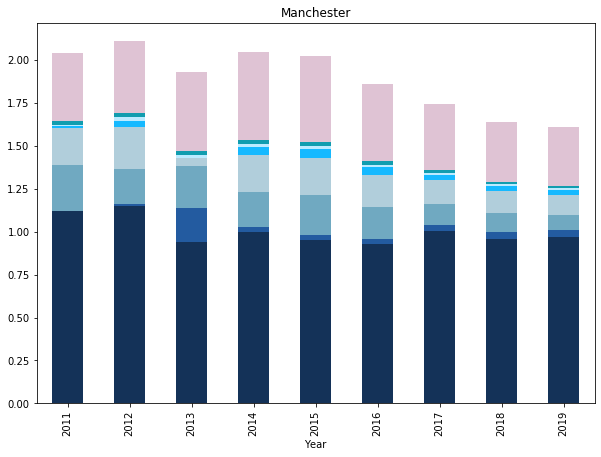

In [304]:
ax = pivot_business.loc[:,['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']].plot.bar(stacked=True, figsize=(10,7), color=['#143258','#235BA0','#70A9C1','#B1CEDB','#16B9FF','#BCEBFF','#119DAF', '#DFC3D4'])
plt.title("Manchester")
ax.get_legend().remove()

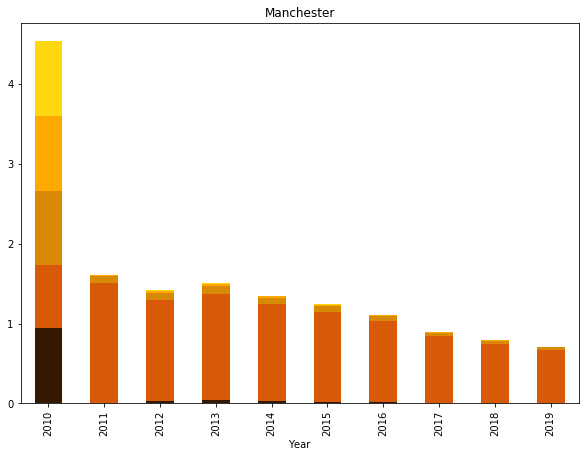

In [305]:
ax = pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7), color=['#351800','#D85907','#D88A07','#FFA900','#FFD70F'])
plt.title("Manchester")
ax.get_legend().remove()

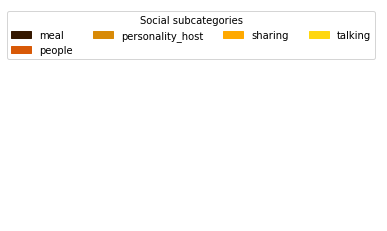

In [90]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create a color palette
palette = dict(zip(['meal','people', 'personality_host', 'sharing', 'talking'], ['#351800','#D85907','#D88A07','#FFA900','#FFD70F']))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
plt.legend(title='Social subcategories', handles=handles, ncol=4)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.show()

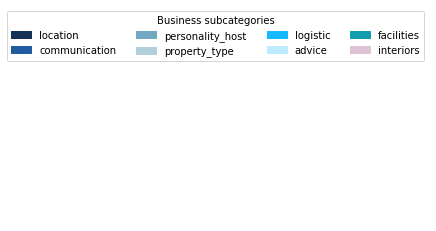

In [91]:
# Create a color palette
palette = dict(zip(['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities', 'interiors'], ['#143258','#235BA0','#70A9C1','#B1CEDB','#16B9FF','#BCEBFF','#119DAF', '#DFC3D4']))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
plt.legend(title='Business subcategories', handles=handles, ncol=4)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.show()